In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('ratings.csv')
data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movie = pd.read_csv('movies.csv',usecols=[0,1])
movie.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [4]:
data = pd.merge(data,movie,on='movieId')
data.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [9]:
import matplotlib.pyplot as plt

In [22]:
ratings = pd.DataFrame(data.groupby('title')['rating'].mean())  
  
ratings['num of ratings'] = pd.DataFrame(data.groupby('title')['rating'].count()) 
  
ratings.sort_values('num of ratings',ascending=False).head(5)


,rating,num of ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278


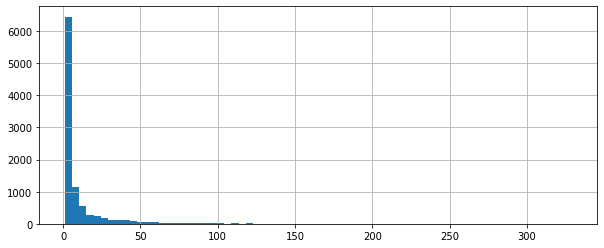

In [11]:
plt.figure(figsize =(10, 4)) 
  
ratings['num of ratings'].hist(bins = 70) 

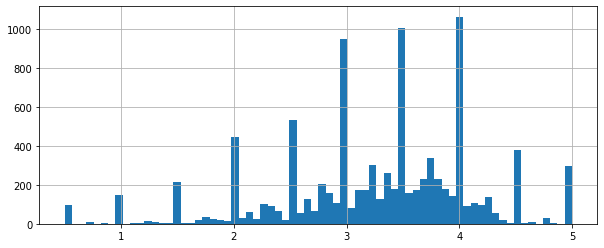

In [12]:
plt.figure(figsize =(10, 4)) 
  
ratings['rating'].hist(bins = 70) 

In [5]:
data = pd.DataFrame(data).sort_values(['userId','movieId'], ascending=[0,1])
data.head()

,userId,movieId,rating,timestamp,title
214,610,1,5.0,1479542900,Toy Story (1995)
368,610,6,5.0,1493850345,Heat (1995)
27682,610,16,4.5,1479542171,Casino (1995)
19121,610,32,4.5,1479543331,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
571,610,47,5.0,1479545853,Seven (a.k.a. Se7en) (1995)


In [57]:
# wrirte a function about finding active user's N favorite movies 
def favoriteMovies(activeUser,N):
    topMovies = pd.DataFrame(data[data.userId==activeUser]).sort_values(['rating'],ascending=False)[:N]
    return list(topMovies.title)
print(favoriteMovies(5,3))

['Dances with Wolves (1990)', 'In the Name of the Father (1993)', "Schindler's List (1993)"]


In [58]:
# create a matrix with userId as row, movieId as columns, and ratings as value

userMovieRatingMatrix = pd.pivot_table(data,values='rating',index='userId',columns='movieId')
userMovieRatingMatrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# write a function about the similaity between two users

from scipy.spatial.distance import correlation

def similarity(user1,user2):
    user1 = np.array(user1)-np.nanmean(user1)
    user2 = np.array(user2)-np.nanmean(user2)
    commonMovies = [i for i in range(len(user1)) if user1[i]>0 and user2[i]>0]
    if len(commonMovies)==0:
        return 0
    else:
        user1 = np.array([user1[i] for i in commonMovies])
        user2 = np.array([user2[i] for i in commonMovies])
        return correlation(user1,user2)

     

In [95]:
# write a function about finding the active user's K neareat neighours' ratings. this will return the predicted rating for movies active user hasn't rated
# will create two matrixs:
# 1. for similatity matrix, the userId will be its row; movieId will be its columns, and the value is similarity
# between other users and active user; the nearest neighbours matrix is just the same matrix as similarity, but just 
# show the nearest neighbour after sorting and subtracting data from similarity matrix. 
# 2. for predicted movie rating: the movieId will be its row, userId will be its columns, and the normolized ratings will be its values.


def nearestNeighbourRatings(activeUser,K):
    similarityMatrix = pd.DataFrame(index=userMovieRatingMatrix.index, columns=['Similarity']) #index=userId. This is an empty matrix
    for i in userMovieRatingMatrix.index:
        similarityMatrix.loc[i] = similarity(userMovieRatingMatrix.loc[activeUser],userMovieRatingMatrix.loc[i]) 
        
    similarityMatrix = pd.DataFrame(similarityMatrix).sort_values(['Similarity'],ascending=False)
    nearestNeighbours = similarityMatrix[:K]
    neighbourMovieRatings = userMovieRatingMatrix.loc[nearestNeighbours.index]
    
    predictedMovieRatings = pd.DataFrame(index=userMovieRatingMatrix.columns,columns=['Rating'] ) 
    for i in userMovieRatingMatrix.columns: 
        predictedRating = np.nanmean(userMovieRatingMatrix.loc[activeUser])
        for j in neighbourMovieRatings.index: 
            if userMovieRatingMatrix.loc[j,i]>0: 
                predictedRating += (userMovieRatingMatrix.loc[j,i]-np.nanmean(userMovieRatingMatrix.loc[j]))*nearestNeighbours.loc[j,'Similarity']
                
                predictedMovieRatings.loc[i,'Rating'] = predictedRating # fill out the empty matrix
    
    return predictedMovieRatings
        
    

In [96]:
# write a function to recommend N movies to active user. this will return the name of the movies
# 1. find the movies the active user already watched and rated
# 2. return back to the predicted movie ratings matrix and drop the movies the active user already watched
# 3. find the recommendation movies based on nearest neighbours, and return the title of the movies.


def topRecommendations(activeUser,N): 
    predictedMovieRatings = nearestNeighbourRatings(activeUser,10) 
   
    movieAlreadyWatched = list(userMovieRatingMatrix.loc[activeUser].loc[userMovieRatingMatrix.loc[activeUser]>0])
    predictedMovieRatings = predictedMovieRatings.drop(movieAlreadyWatched) 
    topRecommendations = pd.DataFrame(predictedMovieRatings).sort_values(['Rating'],ascending=False)[:N] 
    topRecommendationTitles = (movie.loc[movie.movieId.isin(topRecommendations.index)])
    
    return list(topRecommendationTitles.title)

In [97]:
# find the active Users 5 favorite movies and recommend 3 movies to he or she based on nearest neigbours

activeUser=5
print(favoriteMovies(activeUser,5),'\n',topRecommendations(activeUser,3))


C:\Users\Zheng Mengyao\Anaconda3\lib\site-packages\scipy\spatial\distance.py:702: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


['Dances with Wolves (1990)', 'In the Name of the Father (1993)', "Schindler's List (1993)", 'Postman, The (Postino, Il) (1994)', 'Pinocchio (1940)'] 
 ['Usual Suspects, The (1995)', 'Shawshank Redemption, The (1994)', 'Fargo (1996)']
